# Perfect-Model Predictability Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

# What's a perfect-model framework simulation?

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

How does it look like?
[See 4.2](#timeseries)

---

Some papers including perfect-model simulations:
- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

---
**This demo:**

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability:
 - DPP
 - variance-weighted mean period
 - decorrelation time
---

In [1]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model, 
                                 xr_predictability_horizon, 
                                 compute_persistence_pm)
from climpred.bootstrap import bootstrap_perfect_model, pseudo_ens
from climpred.loadutils import get_datasets, open_dataset

from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr, DPP)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **ensemble**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [2]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

### Choose varname, area, period

In [3]:
varname='tos'
area='global'
period='ym'

In [4]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

# Bootstrap with replacement
Goddard et al. 2013

In [5]:
sig = 95
pers_sig = 95
bootstrap = 50 
comparison='m2e'

init_skill = compute_perfect_model(ds_, control_, metric='pearson_r', 
                                   comparison=comparison)
ds_uninit = pseudo_ens(ds_, control_)
uninit_skill = compute_perfect_model(ds_uninit, control_, metric='pearson_r', 
                                     comparison=comparison).mean('lead')

In [6]:
bootstrapped = bootstrap_perfect_model(ds_, control_, metric='pearson_r', 
                                       comparison=comparison, bootstrap=bootstrap, 
                                       sig=sig, compute_persistence_skill=True,
                                       pers_sig=pers_sig)

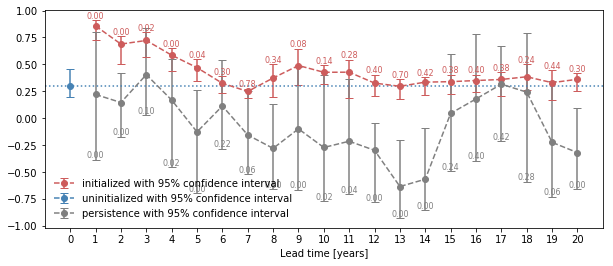

In [7]:
from climpred.graphics import plot_bootstrapped_skill_over_leadyear
pers_skill = compute_persistence_pm(ds_, control_)
plot_bootstrapped_skill_over_leadyear(init_skill,
                                      bootstrapped.init_ci,
                                      uninit_skill,
                                      bootstrapped.uninit_ci,
                                      sig,
                                      p_uninit_over_init=bootstrapped.p_uninit_over_init,
                                      pers_skill=pers_skill,
                                      pers_ci=bootstrapped.pers_ci,
                                      pers_sig=pers_sig,
                                      p_pers_over_init=bootstrapped.p_pers_over_init)

### Proposal to reduce returned objects
sig and pers_sig can be obtained from pers.isel(results=1).results.values

this would reduce bootstrap_perfect_model to return init, uninit, pers, where the later have also pvalues

In [8]:
pers_skill = compute_persistence_pm(ds_, control_)

In [9]:
bootstrapped

<xarray.Dataset>
Dimensions:             (lead: 20, quantile: 2)
Coordinates:
  * lead                (lead) int64 1 2 3 4 5 6 7 8 ... 13 14 15 16 17 18 19 20
  * quantile            (quantile) float64 0.025 0.975
    period              <U2 'ym'
    area                <U6 'global'
Data variables:
    init_ci             (quantile, lead) float64 0.7244 0.4997 ... 0.4442 0.4197
    uninit_ci           (quantile) float64 0.1998 0.457
    pers_ci             (quantile, lead) float64 -0.3856 -0.1731 ... 0.09673
    p_uninit_over_init  (lead) float64 0.0 0.0 0.02 0.0 ... 0.38 0.24 0.44 0.3
    p_pers_over_init    (lead) float64 0.0 0.0 0.1 0.02 ... 0.42 0.28 0.06 0.0

In [10]:
p_pers_over_init=bootstrapped['p_pers_over_init'].expand_dims('quantile')
p_pers_over_init['quantile']=['p']
pers_ci = bootstrapped['pers_ci']
pers_skill=pers_skill.expand_dims('quantile')
pers_skill['quantile']=['skill']
pers=xr.merge([pers_skill, pers_ci,p_pers_over_init]).rename({'quantile':'results'})
pers.drop(['area','period'])

<xarray.Dataset>
Dimensions:           (lead: 20, results: 4)
Coordinates:
  * results           (results) object 'skill' 0.025 0.975 'p'
  * lead              (lead) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
Data variables:
    tos               (results, lead) float32 0.21984895 0.14496486 ... nan nan
    pers_ci           (results, lead) float64 nan nan nan nan ... nan nan nan
    p_pers_over_init  (results, lead) float64 nan nan nan nan ... 0.28 0.06 0.0

In [11]:
pers.sel(results='skill')['tos']

<xarray.DataArray 'tos' (lead: 20)>
array([ 0.219849,  0.144965,  0.403938,  0.168348, -0.128397,  0.112624,
       -0.157037, -0.281331, -0.099988, -0.27324 , -0.214975, -0.299512,
       -0.636091, -0.568219,  0.043728,  0.178099,  0.315915,  0.241175,
       -0.225292, -0.321113], dtype=float32)
Coordinates:
    results  <U5 'skill'
    period   <U2 'ym'
    area     <U6 'global'
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

### How does a perfect-model framework simulation look like?

<a id='timeseries'></a>

In [12]:
def _get_limit_sig(metric='pearson_r',sig=99):
    """Adjust limit and significance level for bootstrapping to metric."""
    if metric in ['pearson_r', 'ppp', 'msss', 'nrmse', 'nmse']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

def _plot_skill(ax, result, color='k', linestyle='-', marker='o', 
                markersize=6, linewidth=2, **kwargs):
    """
    Quick function to plot results of predictability analysis.
    """
    p = ax.plot(result.lead, result, color=color, linestyle=linestyle, 
                marker=marker, markersize=markersize, linewidth=linewidth, 
                **kwargs)
    return p

pearson_r
rmse
mse
ppp
nrmse
nmse


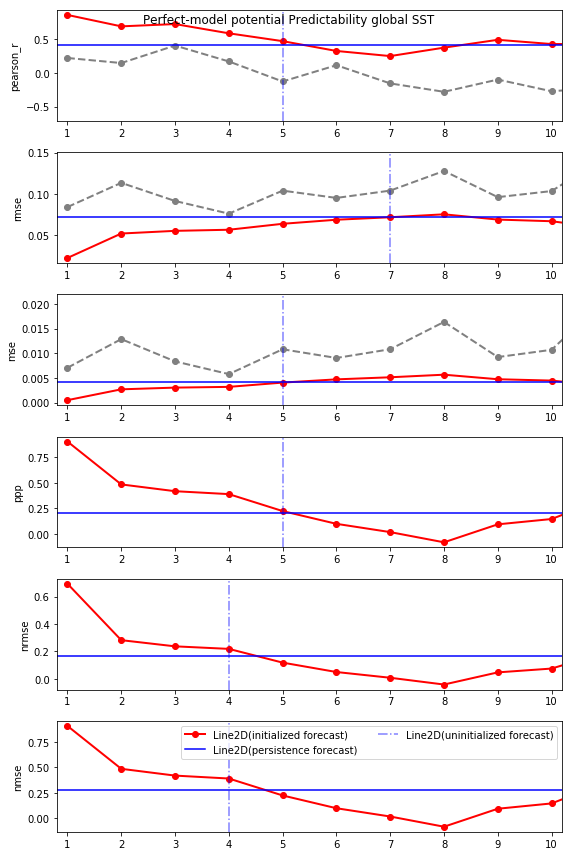

In [13]:
comparison='m2e'
sig=95
bootstrap=10
# Main plot.
metrics = ['pearson_r', 'rmse', 'mse', 'ppp', 'nrmse','nmse']
f, axs = plt.subplots(nrows=len(metrics), ncols=1,figsize=(8,12))

for ax, metric in zip(axs, metrics):
    print(metric)
    ip = compute_perfect_model(ds_, control_, metric=metric, 
                               comparison=comparison)
    up = bootstrap_perfect_model(ds_, control_, metric=metric, 
                                 comparison=comparison, sig=sig,
                                 bootstrap=bootstrap,
                                 compute_persistence_skill=False)['uninit_ci'].isel(quantile=1)
    if metric in ['rmse', 'mse', 'pearson_r']:
        persist = compute_persistence_pm(ds, control_, metric=metric)
        p = _plot_skill(ax, persist, color='gray', linestyle='--', 
                        label='persistence forecast')
    i = _plot_skill(ax, ip, color='r', label='initialized forecast')
    u = ax.axhline(y=up, color='blue', linewidth=1.5, 
                   label='uninitialized forecast')
    # predictability horizon
    limit, sig = _get_limit_sig(metric=metric)
    ph = xr_predictability_horizon(ip, up, limit=limit, 
                                   perfect_model=True).values
    php = ax.axvline(x=ph, color='blue', alpha=.5, ls='-.', 
                     label='predictability horizon')

    fac = 1.1
    #ax.set_ylim([fac * min(0, up, ip.min('time'),persist.min('time')),fac * max(up, ip.max('time'),persist.max('time'))])
    ax.set_xlim([0.8, 10.2])
    ax.set_xticks(np.arange(1.,11.),minor=False)
    ax.set_ylabel(metric)
    persist=persist-persist

plt.suptitle('Perfect-model potential Predictability global SST')

plt.legend([i[0], p[0], u, php],ncol=2)
plt.tight_layout()

## Different comparisons lead to different skill score magnitude by design

e2c
m2c
m2e
m2m


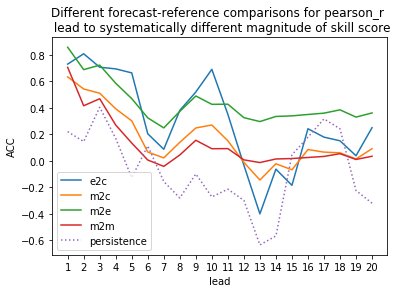

In [14]:
for c in ['e2c','m2c','m2e','m2m']:
    print(c)
    compute_perfect_model(ds_, control_, metric='pearson_r', comparison=c).plot(label=c)
compute_persistence_pm(ds_, control_).plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

Can we adapt persistence forecast to the references? What's a fair comparison for persistence?

# 3-dimensional

## 3-dimensional output
Data is stored on curvilinear grid: lon(y, x), lat(y, x)

In [15]:
ds3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds3d.nc').sel(init=3014).expand_dims('init')[varname]
control3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control3d.nc')[varname]

## Choose predictability metric and comparison

In [16]:
metric='rmse'
comparison='m2e'
sig=99
bootstrap=10

## Skill for Lead Year

In [17]:
skill3d = compute_perfect_model(ds3d, control3d, metric=metric, comparison=comparison)

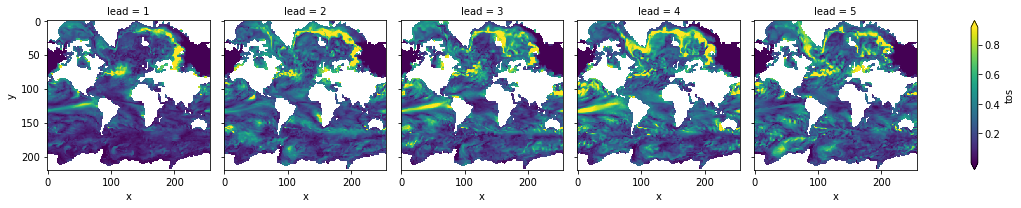

In [18]:
skill3d.plot(robust=True,yincrease=False, col='lead')

## significant skill from bootstrapping

In [19]:
limit, sigl = _get_limit_sig(metric=metric)
bootstrap3d = bootstrap_perfect_model(ds3d, control3d, metric=metric, comparison=comparison, 
                     sig=sigl, bootstrap=bootstrap)

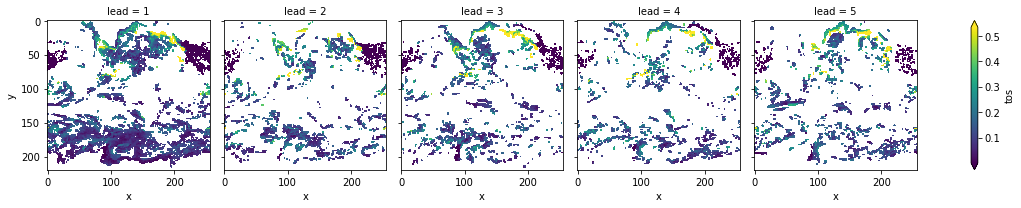

In [20]:
skill3d.where(bootstrap3d['p_uninit_over_init'] < .05).plot(yincrease=False, col='lead',robust=True)

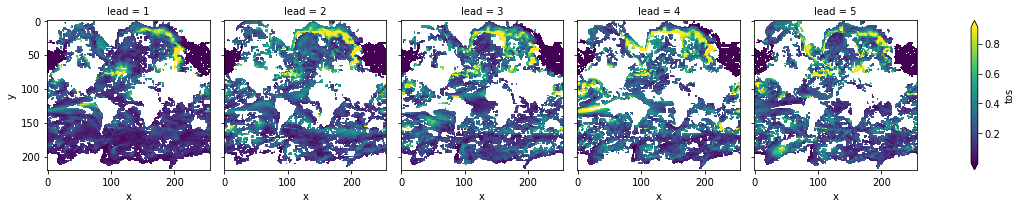

In [21]:
skill3d.where(bootstrap3d['p_pers_over_init'] < .05).plot(yincrease=False, col='lead',robust=True)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances of predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [22]:
help(DPP)

Help on function DPP in module climpred.stats:

DPP(ds, m=10, chunk=True)
    Calculate Diagnostic Potential Predictability (DPP) as potentially
    predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Resplandy et al. 2015 and Seferian et al. 2018 calculate unbiased DPP
    in a slightly different way. chunk=False
    
    .. math::
    
    DPP_{       ext{unbiased}}(m)=rac{\sigma^2_m - 1/m \cdot \sigma^2}{\sigma^2}
    
    References:
    * Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    * Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    * Séférian, Roland, Sarah Berthet, and Matthieu Chevallie

### Resplandy 2015, Seferian 2018 method

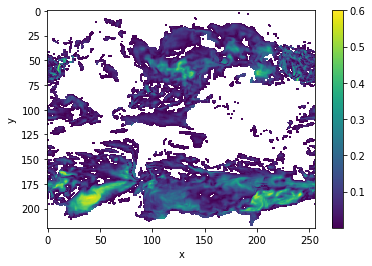

In [23]:
DPP10 = DPP(control3d, m=10, chunk=False)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

### Original Boer 2004 implementation

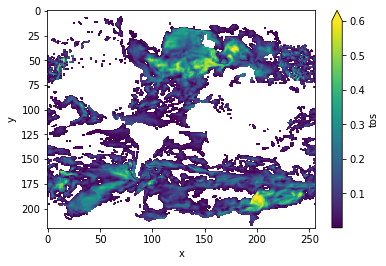

In [24]:
DPP10 = DPP(control3d, m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

yields similar results

## varweigthed mean period

In [25]:
help(xr_varweighted_mean_period)

Help on function xr_varweighted_mean_period in module climpred.stats:

xr_varweighted_mean_period(ds, time_dim='time')
    Calculate the variance weighted mean period of time series.
    
    ..math:
        P_x = \sum_k V(f_k,x) / \sum_k f_k V(f_k,x)
    
    Reference:
      * Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value
        Decadal Predictability in a CGCM." Journal of Climate 23, no. 23
        (August 27, 2010): 6292-6311. https://doi.org/10/bwq92h.
    
    Args:
        ds (xarray object): Time series.
        time_dim (optional str): Name of time dimension.



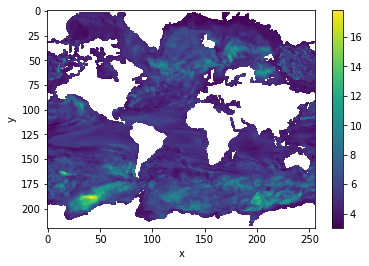

In [26]:
from climpred.stats import xr_varweighted_mean_period as xvmp
varweighted_mean_period = xvmp(control3d,time_dim='time')
varweighted_mean_period.plot(yincrease=False)

## Lag1 autocorrelation

In [27]:
help(xr_autocorr)

Help on function xr_autocorr in module climpred.stats:

xr_autocorr(ds, lag=1, dim='time', return_p=False)
    Calculate the lagged correlation of time series.
    
    Args:
        ds (xarray object): Time series or grid of time series.
        lag (optional int): Number of time steps to lag correlate to.
        dim (optional str): Name of dimension to autocorrelate over.
        return_p (optional bool): If True, return correlation coefficients
                                  and p values.
    
    Returns:
        Pearson correlation coefficients.
    
        If return_p, also returns their associated p values.



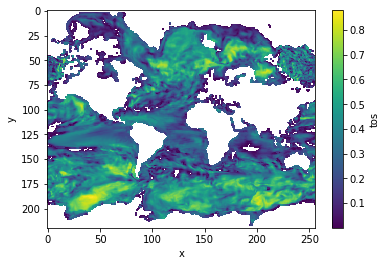

In [28]:
corr_ef = xr_autocorr(control3d,dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [29]:
help(xr_decorrelation_time)

Help on function xr_decorrelation_time in module climpred.stats:

xr_decorrelation_time(da, r=20, dim='time')
    Calculate the decorrelaton time of a time series.
    
    .. math::
        tau_{d} = 1 + 2 * \sum_{k=1}^{\inf}(alpha_{k})^{k}
    
    Reference:
        * Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
          Research. Cambridge ; New York: Cambridge University Press, 1999.,
          p.373
    
    Args:
        da (xarray object): Time series.
        r (optional int): Number of iterations to run the above formula.
        dim (optional str): Time dimension for xarray object.
    
    Returns:
        Decorrelation time of time series.



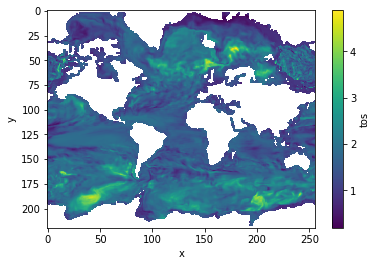

In [30]:
decorr_time = xr_decorrelation_time(control3d)
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)